<a href="https://colab.research.google.com/github/sanadelph/pcg_binary_classification/blob/main/pcg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
import os
import sys
!{sys.executable} -m pip install deap
!{sys.executable} -m pip install bitstring
!{sys.executable} -m pip install python_speech_features


from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from random import shuffle
import math
from tensorflow import keras
from keras.layers import LSTM, Input, Dense, Bidirectional, Dropout
from keras.models import Model, Sequential
from deap import base, creator, tools, algorithms
from bitstring import BitArray
from scipy.io import wavfile
from scipy.stats import bernoulli
from python_speech_features import mfcc
import IPython
import librosa
import matplotlib.pyplot as plt

time_steps=450
nfft=1203
mfcc_features = list()


drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def normalize(v):
  norm = np.linalg.norm(v)
  if norm == 0:
    return v
  return v/norm


def get_mfcc(folder,trainingFolders):
    waves=[]
    mfcc_features = []
    for tf in trainingFolders:
      dataset = pd.read_csv('/content/drive/MyDrive/{}/{}/REFERENCE.csv'.format(folder,tf), header=None, names =['filename', 'outcome'])
      waves.append(dataset)

    wav=pd.concat(waves)
    print(wav)
    # wave_list = []
    # wave_name = []

    # wav.outcome.replace(to_replace=-1, value=0, inplace=True) #replacing -1 lable of Normal wave to 0


    tt=0
    for tf in trainingFolders:
      for fname in wav.filename:
          path_wav = "/content/drive/MyDrive/{}/{}/{}.wav".format(folder,tf,fname)
          if os.path.exists(path_wav):
            sampFreq, audio = wavfile.read(path_wav)            # Return the sample rate (in samples/sec) and data from a WAV file
            label=0
            # wave_list.append(audio)
            # wave_name.append(fname)
            path_hea= "/content/drive/MyDrive/{}/{}/{}.hea".format(folder,tf,fname)
            with open(path_hea,'r') as f:
              for line in f:
               for word in line.split():
                 if(word=="Abnormal"):
                  label=1

            # now we have the label stored in 'label' and the audio as 'audio' with sampling freq. as 'sampling_freq'.\n",
            temp = mfcc(audio, sampFreq, nfft=nfft)
            temp = temp[tt:tt+time_steps,:]
            mfcc_features.append({"label": label, "mfcc": temp})

    # mfcc features of this audio has been appended to the list ,
    return mfcc_features

train_files = list()
mfcc_features = get_mfcc('training',['training-a','training-b','training-c','training-d','training-e','training-f'])
# test_features = get_mfcc('validation',['validation'])
print("mfcc size:",len(mfcc_features))
# print("test mfcc size:",len(test_features))
shuffle(mfcc_features)
# shuffle(test_features)

    filename  outcome
0      a0001        1
1      a0002        1
2      a0003        1
3      a0004        1
4      a0005        1
..       ...      ...
109    f0110       -1
110    f0111       -1
111    f0112       -1
112    f0113       -1
113    f0114       -1

[3240 rows x 2 columns]
mfcc size: 3240


In [8]:
size = (8*len(mfcc_features))/10
train_features = mfcc_features[0:int(size)]
test_features = mfcc_features[int(size):]
train_size = 0
for feature in train_features:
    train_files.append({'label': feature["label"], 'feature': feature["mfcc"] })
    train_size += 1
# Train rnn for each MFCC and add to training set
x_train = np.zeros((train_size, time_steps ,13))
y_train = np.zeros((train_size))
i = 0
for train_file in train_files:
    # print(train_file['feature'])
    # print(train_file['label'])
    x_train[i,:,:] = train_file['feature']
    y_train[i] = train_file['label']
    i += 1
x_train=normalize(x_train)

############   TESTING DATA   ###########
test_files = list()
# test_features = test_mfcc_features
test_size = 0
for feature in test_features:
  test_files.append({'label': feature["label"], 'feature': feature["mfcc"] })
  test_size += 1
x_test = np.zeros((test_size, time_steps ,13))
y_test = np.zeros((test_size))
i = 0
for test_file in test_files:
    x_test[i,:,:] = test_file['feature']
    y_test[i] = test_file['label']
    i += 1
x_test=normalize(x_test)
print('-------MFCC feature extraction finished-------')


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


-------MFCC feature extraction finished-------
(2592, 450, 13)
(2592,)
(648, 450, 13)
(648,)


In [13]:
def baseline_classifier(x_train,y_train,x_test,y_test):
  stratified_classifier = DummyClassifier(strategy='stratified', random_state=42)
  stratified_classifier.fit(x_train, y_train)
  y_pred = stratified_classifier.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy



def train_evaluate(ga_individual_solution):
    # Decode GA solution to integer for num_neurons, epochs
    num_neurons1_bits = BitArray(ga_individual_solution[:8])
    num_neurons2_bits = BitArray(ga_individual_solution[8:16])
    epoch_bits = BitArray(ga_individual_solution[16:])

    num_neurons1 = num_neurons1_bits.uint
    num_neurons2 = num_neurons2_bits.uint
    epoch = epoch_bits.uint


    print('\nNum of neurons1: ', num_neurons1,'\nNum of neurons2',num_neurons2, '\nEpoch:', epoch)

    # Return fitness score of 0 if num_neurons1 < 100 or num_neurons2 < 100 or epoch < 100
    if num_neurons1 <= 0 or num_neurons2 <= 0 or epoch <= 1:
      return 0,

    #split into train and validation (80/20)
    X_train,X_test,Y_train,Y_test=train_test_split(x_train,y_train,test_size=0.2)
    #Design the LSTM model

    # optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model = Sequential()
    model.add(LSTM(units=num_neurons1, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=num_neurons2))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()

    history=model.fit(X_train, Y_train, epochs=epoch, verbose=0)
    # Y_pred = model.predict(X_test)
    val_accuracy=model.evaluate(x=X_test,y=Y_test)[1]
    print(f"Validation accuracy: ", val_accuracy)


    return val_accuracy,




population_size = 8
num_generations = 4
gene_length = 20
# As we are trying to minimize the RMSE score, that's why using -1.0.
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)


best_individual = tools.selBest(population,k = 1)
best_num_neurons1 = None
best_num_neurons2 = None
best_epoch = None

for bi in best_individual:
  num_neurons1_bits = BitArray(bi[0:8])
  num_neurons2_bits = BitArray(bi[8:16])
  epoch_bits = BitArray(bi[16:])

  best_num_neurons1 = num_neurons1_bits.uint
  best_num_neurons2 = num_neurons2_bits.uint
  best_epoch = epoch_bits.uint

print('\nBest Num of neurons1: ', best_num_neurons1, '\nBest Num of neurons2: ',
        best_num_neurons2,'\nBest Epoch:', best_epoch)



Num of neurons1:  185 
Num of neurons2 83 
Epoch: 14
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 450, 185)          147260    
                                                                 
 dropout_62 (Dropout)        (None, 450, 185)          0         
                                                                 
 lstm_63 (LSTM)              (None, 83)                89308     
                                                                 
 dropout_63 (Dropout)        (None, 83)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 84        
                                                                 
Total params: 236652 (924.42 KB)
Trainable params: 236652 (924.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_106 (LSTM)             (None, 450, 252)          268128    
                                                                 
 dropout_106 (Dropout)       (None, 450, 252)          0         
                                                                 
 lstm_107 (LSTM)             (None, 59)                73632     
                                                                 
 dropout_107 (Dropout)       (None, 59)                0         
                                                                 
 dense_53 (Dense)            (None, 1)                 60        
                                                                 
Total params: 341820 (1.30 MB)
Trainable params: 341820 (1.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/7
57/57 [

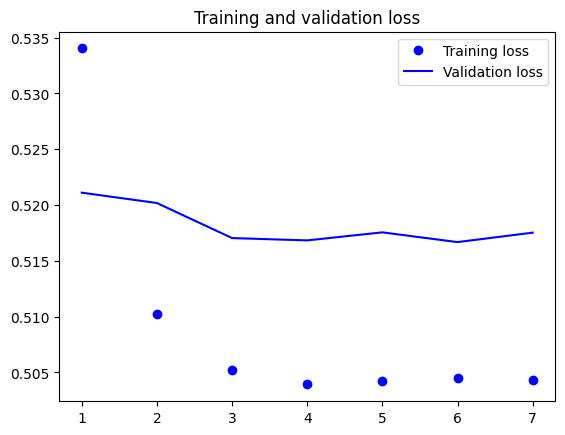

21/21 [==============================] - 9s 447ms/step - loss: 0.5165 - accuracy: 0.7886
GA Optimized Model Test Accuracy: 78.86
Baseline Classifier Accuracy: 65.43


In [14]:
from sklearn.metrics import accuracy_score

model = Sequential()
model.add(LSTM(units=best_num_neurons1, input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=best_num_neurons2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

history=model.fit(x_train, y_train, validation_split = 0.3, epochs=best_epoch, batch_size=32)


import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


print(f"GA Optimized Model Test Accuracy: {model.evaluate(x=x_test,y=y_test)[1]*100:.2f}")
print(f"Baseline Classifier Accuracy: {baseline_classifier(x_train,y_train,x_test,y_test)*100:.2f}")